# A Tutorial on Generating a Synthetic Dataset for Computational Single Particle Imaging

The purpose of this tutorial is to generate a synthetic dataset of diffraction patterns and their associated orientations for computational Single Particle Imaging (cSPI). The tutorial first discusses general diffraction theory. The tutorial then introduces steps on installing Pysingfel, a Python-based SPI Simulation for Free-Electron Lasers. Using Pysingfel, the tutorial setups and simulates an SPI Experiment. Lastly, the diffraction patterns and orientations are collected from the SPI experiment to create the synthetic dataset.

## Table of Contents <a id='TOC'></a>
* [Diffraction Theory](#theory)
* [Installing pysingfel](#installation)
* [Running an SPI experiment](#experiment)
  - [Using the Experiment method](#a1-experiment)
    - [Create a dataset](#a1-make-dataset)
    - [Save the dataset](#a1-save-dataset)
  - [Efficient and scalable method](#a2-experiment)
* [Interactive visualization](#interactive)

## Diffraction Theory <a id='theory'></a>

<table>
<tr>
<td>
<b>
Establishing the relation between the detector and reciprocal space
</b>
<br><br>
From this geometry shown on the right, the relationship between the
detector and the reciprocal space is given by 
<br><br>
$$\vec{q} = (q_x, q_y, q_z) = \vec{k}_{out} - \vec{k}_{in}$$
$$q = \frac{2}{\lambda} \sin \theta$$
$$q_x = q(1 - \frac{\lambda^2 q^2}{4})^\frac{1}{2} \sin (\arctan2(x, y))$$
$$q_y = q(1 - \frac{\lambda^2 q^2}{4})^\frac{1}{2} \cos (\arctan2(x, y))$$
$$q_z = -\frac{\lambda}{2}q^2$$
<br>
where $\vec{q}$ is the scattering vector, $\lambda$ is the wavelength, and $2\theta$ is the angle between the incident and scattered wave vector $k_{in}$ and $k_{out}$, respectively. The coordinates $(x, y)$ denote the position of the detector pixel, which has a corresponding point $(q_x, q_y, q_z)$ in reciprocal space located on the Ewald sphere.
<br><br>
<b>Determining the photon count for a pixel on the detector</b><br><br>
If $D$ is the particle diameter, $\Phi$ is the incident flux, $o$ is the oversampling ratio, and $r_e$ is the electron radius, then the expected photon count $n(q)$ for a pixel on the detector
can then be determined by
    <br><br>
$$n(q) = \Phi r_e^2 |F(\vec{q})|^2\left(\frac{\lambda}{oD}\right)^2$$
    <br>
for small scattering angles $2\theta$ where
    <br><br>
$$F(\vec{q}) = \sum_{j=1}^N f_j(q) \exp (2 \pi i \vec{q} \cdot X_j')$$
    <br>
is the structure factor, $f_j$ is the $j^{th}$ atomic form factor, and $X_j' = RX_j$ where $R$ here is the matrix that rotates the particle, represented by the three-dimensional atomic coordinates $X_j=\{(x_j, y_j, z_j)\}$, to a new position $X_j'=\{(x'_j,y'_j,z'_j)\}$.
<br><br><b>
On rotations
</b><br><br>
To account for random orientations of the particle, simulators often generate uniform random rotations. 
Since a rotation $R$ can be represented as the quaternion $\vec{q_R} = (q_r, q_i, q_j, q_k)$,
a uniform random rotation can be generated by letting<br><br>
$$q_r = \sin(2 \pi X_1)  \sqrt{1 - X_0}$$
$$q_i = \cos(2 \pi X_1)  \sqrt{1 - X_0}$$
$$q_j = \sin(2 \pi X_2)  \sqrt{X_0}$$
$$q_k = \cos(2 \pi X_2)  \sqrt{X_0}$$<br>
where $X_0$, $X_1$, and $X_2$ are three independent random variables uniformly distributed between [$0$, $1$). 
<br>
<br>
<b>Shot noise<br>
</b>
<br>
Simulators often account for <i>shot noise<i> by assuming that the actual photon count $N$ follows Poisson statistics.<br><br>
$$N \sim \text{Poi}(n(q))$$
<br>
Adapted from I. Poudyal, M. Schmidt, and P. Schwander, “Single-particle imaging by x-ray free-electron lasers—How many snapshots are needed?,” Structural Dynamics, 7(2):24102 (2020) and K. Shoemake. Uniform random rotations. In D. Kirk, editor, Graphics Gems III, pages 124-132. Academic, New York, 1992.
</td>
<td> 
<img src="images/cspi_generate_synthetic_dataset_Fig1.png" style="width: 1500px;"/>
</td>
</tr>
</table>

[[back to TOC](#TOC)]

## Gather dependencies for the SPI Simulation <a id='installation'></a>

To create the synthetic dataset, we will need to install Pysingfel and import the software dependencies needed to simulate an SPI Experiment and create the synthetic dataset.

The following instructions can be used to install Pysingfel on the SLAC pslogin node, but should be similar for other machines.

```bash
ssh YOURACCOUNTNAME@pslogin.stanford.edu
git clone https://github.com/chuckie82/pysingfel.git
cd pysingfel
python setup.py install --user
cd examples/input
source download.sh && tar -xvf lcls.tar.gz
```

Then navigate to https://pswww.slac.stanford.edu/ in your browser and use JupyterHub to open this notebook from the ```examples``` directory

Once the notebook is open, we will then need to import Pysingfel along with other software dependencies needed to create the synthetic dataset:

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#import time
import os
import sys

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize

import h5py as h5

import pysingfel as ps

[[back to TOC](#TOC)]

## Run an SPI experiment <a id='experiment'></a>

### Approach 1 - Using the Experiment class/method <a id='a1-experiment'></a>

We will simulate an SPI Experiment to create the synthetic dataset. To simulate the experiment, we will require the following:
- A PDB, in this case [3iyf](https://www.rcsb.org/structure/3IYF), a protein found in a bacteria
- The beam parameters of an AMO instrument
- The geometry parameters of a pnCCD detector

In this simulated experiment, a collection of two-dimensional diffraction patterns of 3iyf will be recorded by the pnCCD detector. These patterns are taken in random orientations [[1]](#[1]). The patterns and orientations will be used to create the synthetic dataset.

In [2]:
input_dir='../input'

# PDB
particle = ps.Particle()
pdbfile=input_dir+'/pdb/3iyf.pdb'
particle.read_pdb(pdbfile, ff='WK')

# Beam parameters
beamfile=input_dir+'/beam/amo86615.beam'
beam = ps.Beam(beamfile)

# Geometry of detector
geom=input_dir+'/lcls/amo86615/PNCCD::CalibV1/Camp.0:pnCCD.1/geometry/0-end.data'
det = ps.PnccdDetector(geom=geom, beam=beam)

# Simulate the SPI Experiment
experiment = ps.SPIExperiment(det, beam, particle)

#### Create the dataset from the simulated experiment <a id='a1-make-dataset'></a>

To create the synthetic dataset, we collect $100$ diffraction patterns and their respective orientations from the simulated experiment. 

In [3]:
dataset_size = 100

diffraction_pattern_height = det.detector_pixel_num_x.item()
diffraction_pattern_width = det.detector_pixel_num_y.item()

orientation_n_components = 4 # orientations are expressed as unit quaternions

diffraction_patterns = np.zeros((dataset_size, diffraction_pattern_height, diffraction_pattern_width))
orientations = np.zeros((dataset_size, orientation_n_components))

for data_index in range(dataset_size):
    diffraction_pattern, orientation = experiment.generate_image(return_orientation=True)
    diffraction_patterns[data_index] = diffraction_pattern
    orientations[data_index] = orientation

In [4]:
print("Shape of diffraction patterns dataset\t: {}".format(diffraction_patterns.shape))
print("Shape of orientations dataset\t\t: {}".format(orientations.shape))

Shape of diffraction patterns dataset	: (100, 1024, 1040)
Shape of orientations dataset		: (100, 4)


To get a better understanding of the dataset, we plot the diffraction patterns in $\log$ scale along with their respective orientations.

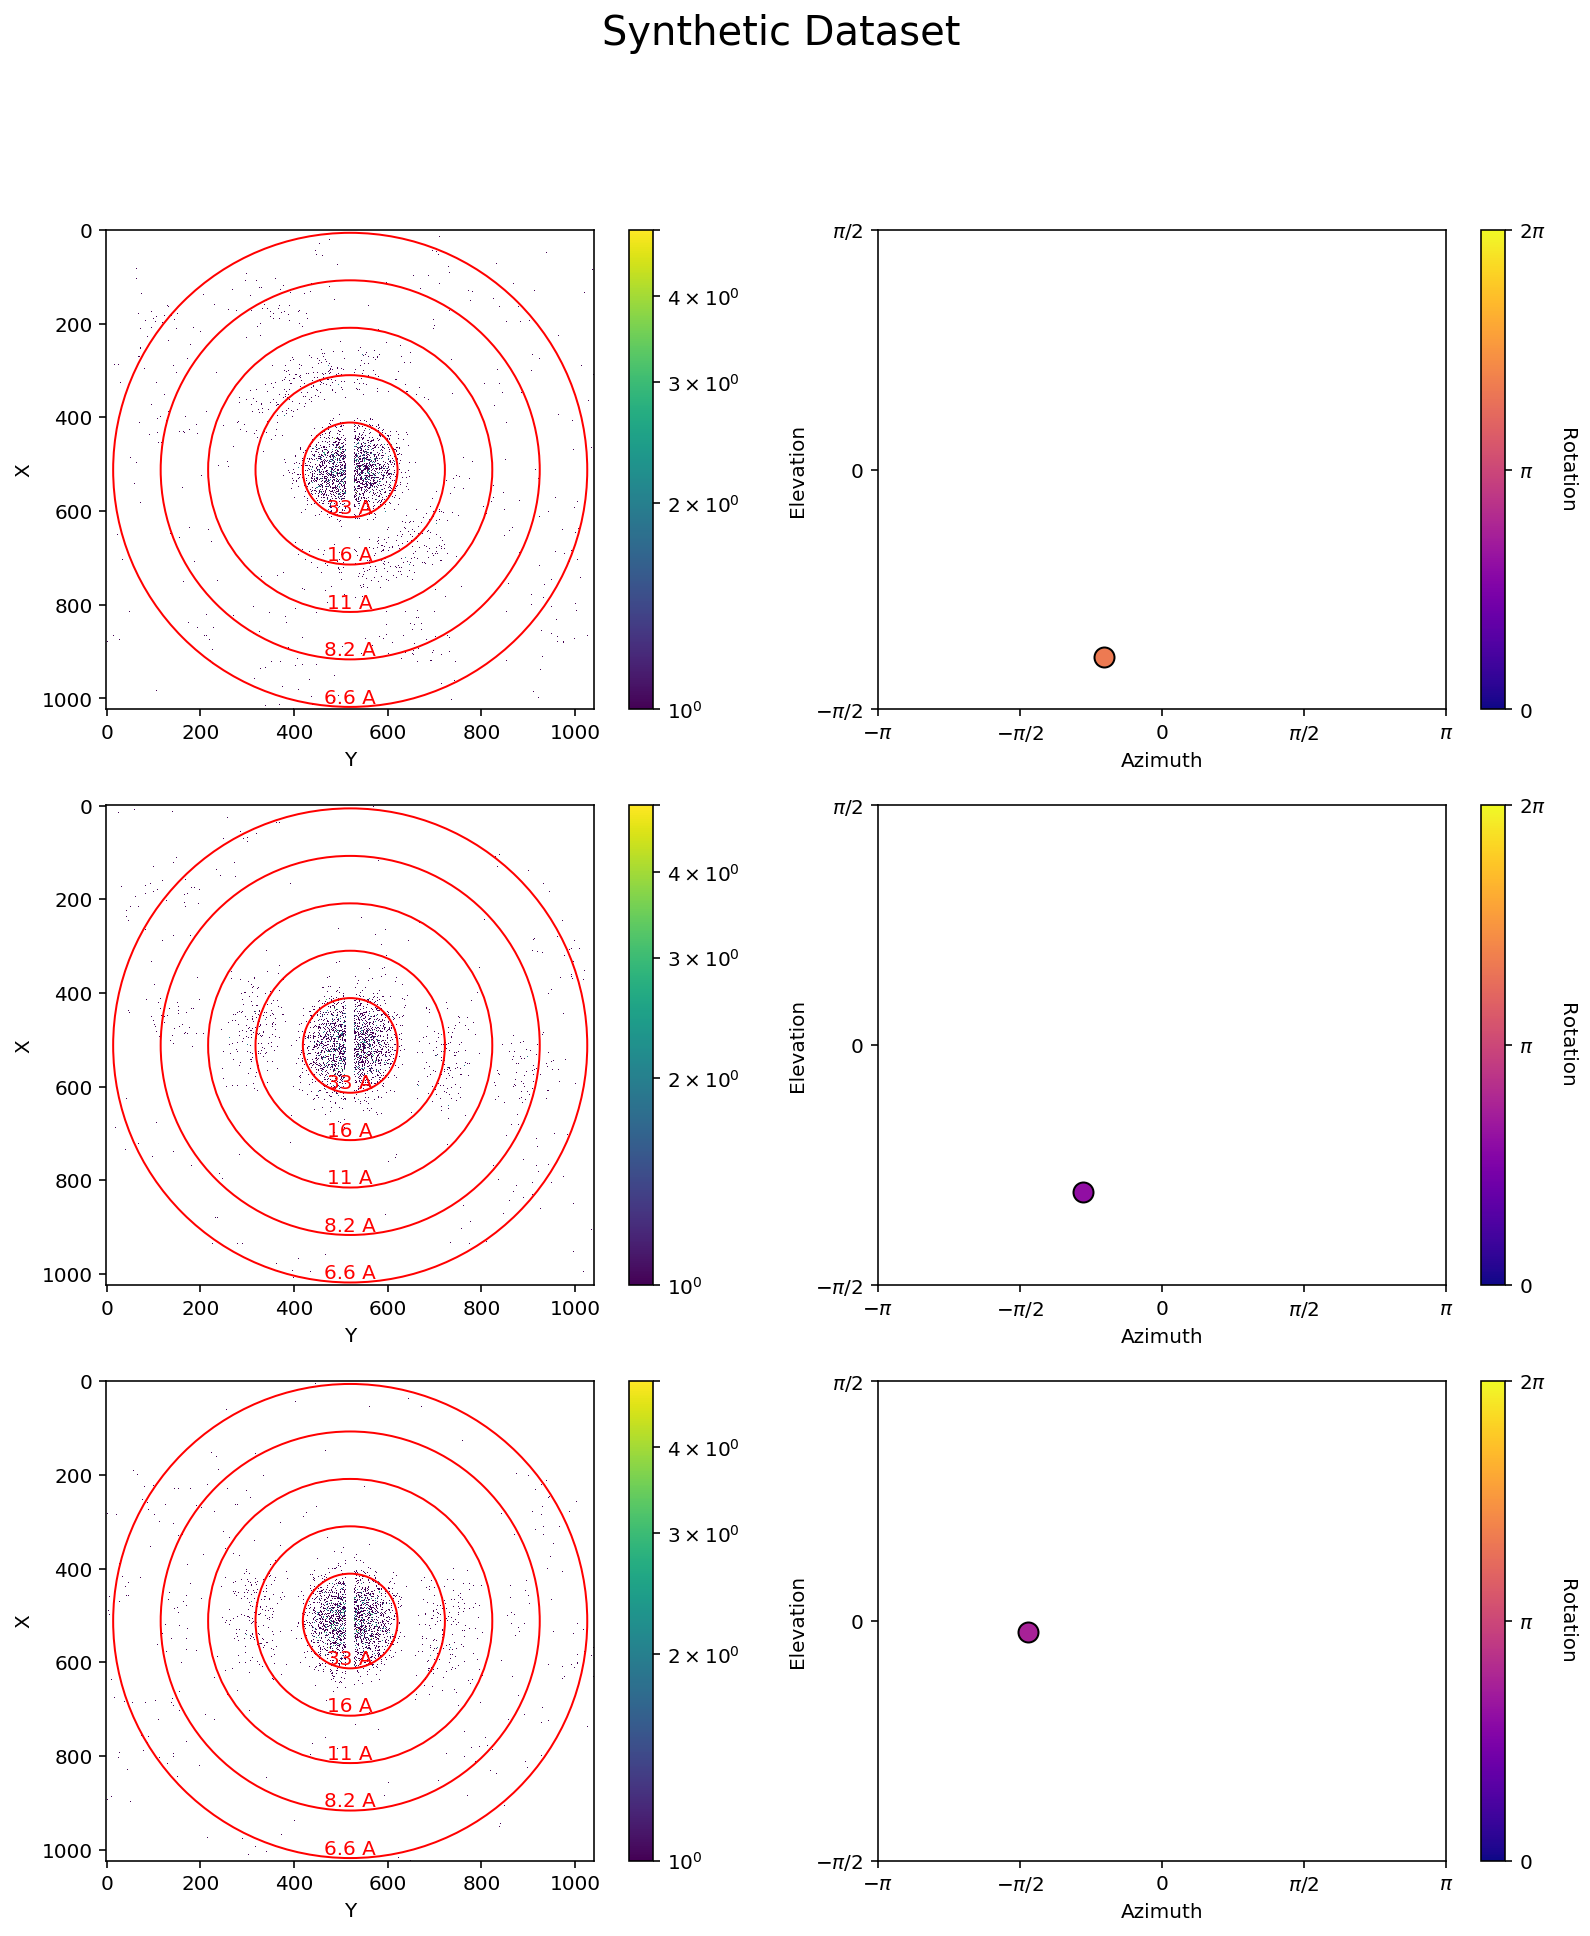

In [5]:
def angle_axis_representation(quaternion):
    q_r = quaternion[0]
    q_ijk = quaternion[1:]
    # https://en.wikipedia.org/wiki/Quaternions_and_spatial_rotation
    q_norm = np.linalg.norm(q_ijk)
    axis = q_ijk / q_norm
    theta = 2 * np.arctan2(q_norm, q_r)
    return axis, theta

def azimuth_elevation_representation(unit_vector):
    x = unit_vector[0]
    y = unit_vector[1]
    z = unit_vector[2]
    # https://en.wikipedia.org/wiki/Spherical_coordinate_system
    azimuth = np.arctan2(y, x)
    elevation = np.arctan2(z, np.sqrt(x ** 2 + y ** 2))
    return azimuth, elevation

def plot_orientation(ax, azimuth, elevation, theta, cmap=cm.plasma):
    norm = Normalize(vmin=0, vmax=2*np.pi)
    color = cmap(norm(theta))
    
    scatter = ax.scatter(azimuth, elevation, color=color, s=100, edgecolors='black')
        
    ax.set_xlabel('Azimuth')
    ax.set_ylabel('Elevation')
    
    ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    ax.set_yticks([-np.pi/2, 0, np.pi/2])
    
    ax.set_xticklabels(['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$'])
    ax.set_yticklabels(['$-\pi/2$', '0', '$\pi/2$'])
    
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ticks=[0, np.pi, 2*np.pi])
    cbar.set_label('Rotation', rotation=270, labelpad=15)
    cbar.ax.set_yticklabels(['0', '$\pi$', '$2\pi$'])  # vertically oriented colorbar

fig_nrows = 3
fig_ncols = 2

fig_width = 14
fig_height = 5 * fig_nrows

plt.figure(figsize=(fig_width, fig_height))
viz = ps.Visualizer(experiment, diffraction_rings="auto", log_scale=True)

for diffraction_pattern_idx, diffraction_pattern in enumerate(diffraction_patterns[:fig_nrows]):
    plt.subplot(fig_nrows, fig_ncols, 2 * (diffraction_pattern_idx + 1) - 1)
    viz.imshow(diffraction_pattern)
    
    orientation = orientations[diffraction_pattern_idx]
    axis, theta = angle_axis_representation(orientation)
    azimuth, elevation = azimuth_elevation_representation(axis)
    
    ax = plt.subplot(fig_nrows, fig_ncols, 2 * (diffraction_pattern_idx + 1))  
    plot_orientation(ax, azimuth, elevation, theta)

plt.suptitle('Synthetic Dataset', fontsize=20)
plt.show()

#### Save the dataset <a id='a1-save-dataset'></a>
We will lastly save the diffraction patterns and orientations collected from the experiment to an HDF5 file.

../output/cspi_synthetic_dataset_diffraction_patterns_1024x1040.hdf5
[u'atomic_coordinates', u'diffraction_patterns', u'orientations']
<HDF5 dataset "diffraction_patterns": shape (100, 1024, 1040), type "<f4">
<HDF5 dataset "orientations": shape (100, 4), type "<f4">
<HDF5 dataset "atomic_coordinates": shape (58624, 3), type "<f4">




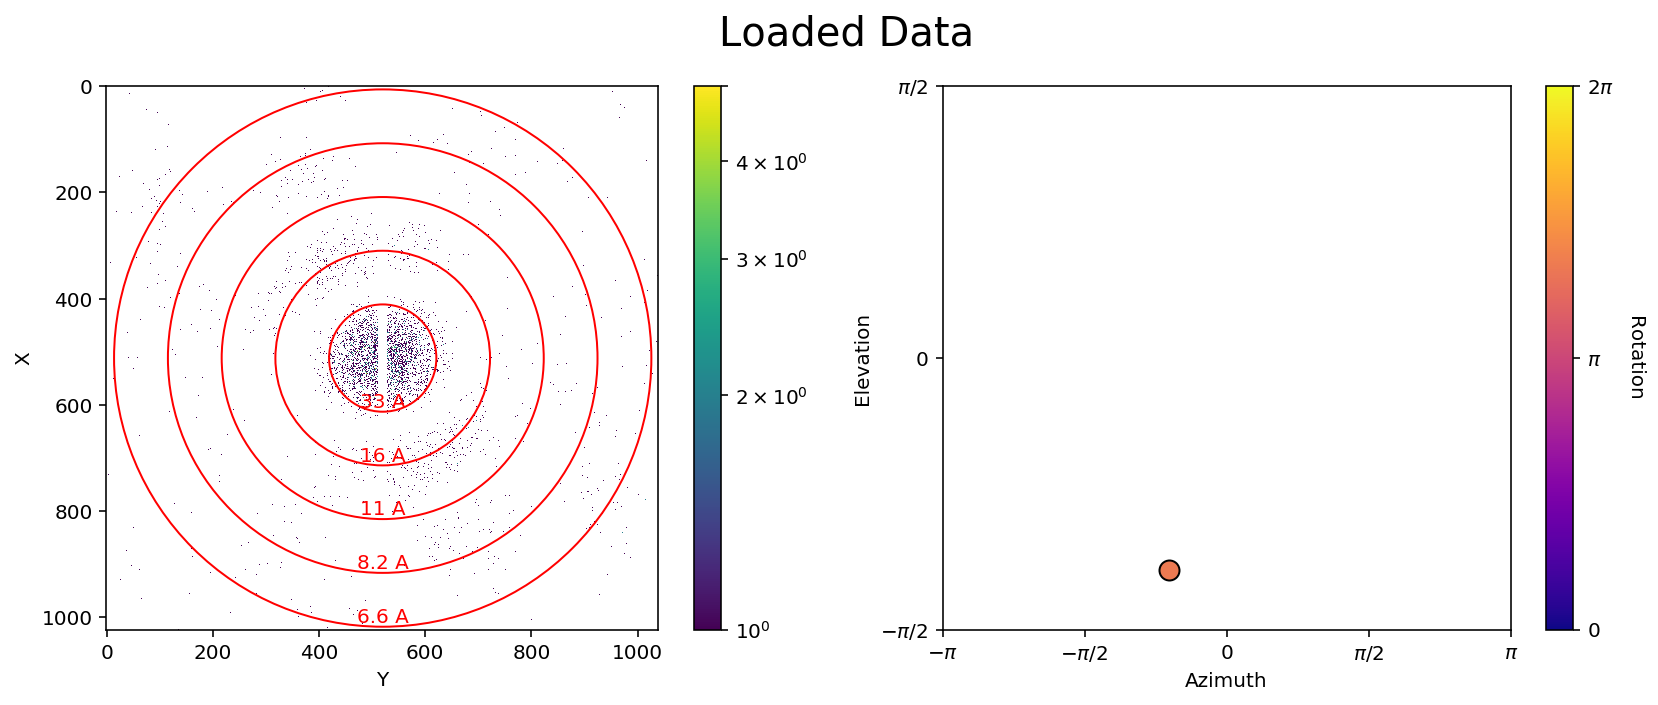

Loaded coordinate of an atom from the particle: [  1.96774996e-09  -3.34739991e-09   2.39729991e-09]


In [6]:
output_dir = '../output'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

cspi_synthetic_dataset_file = os.path.join(output_dir, 'cspi_synthetic_dataset_diffraction_patterns_{}x{}.hdf5'.format(diffraction_patterns.shape[1], diffraction_patterns.shape[2]))
print(cspi_synthetic_dataset_file)

diffraction_patterns_dataset_name = "diffraction_patterns"
orientations_dataset_name = "orientations"
atomic_coordinates_dataset_name = "atomic_coordinates"

with h5.File(cspi_synthetic_dataset_file, "w") as cspi_synthetic_dataset_file_handle:
    dset_diffraction_patterns = cspi_synthetic_dataset_file_handle.create_dataset(diffraction_patterns_dataset_name, diffraction_patterns.shape, dtype='f')
    dset_diffraction_patterns[...] = diffraction_patterns
    dset_orientations = cspi_synthetic_dataset_file_handle.create_dataset(orientations_dataset_name, orientations.shape, dtype='f')
    dset_orientations[...] = orientations
    dset_atomic_coordinates = cspi_synthetic_dataset_file_handle.create_dataset(atomic_coordinates_dataset_name, particle.atom_pos.shape, dtype='f')
    dset_atomic_coordinates[...] = particle.atom_pos
    
with h5.File(cspi_synthetic_dataset_file, "r") as cspi_synthetic_dataset_file_handle:
    print(list(cspi_synthetic_dataset_file_handle.keys()))
    print(cspi_synthetic_dataset_file_handle[diffraction_patterns_dataset_name])
    print(cspi_synthetic_dataset_file_handle[orientations_dataset_name])
    print(cspi_synthetic_dataset_file_handle[atomic_coordinates_dataset_name])
    
    loaded_diffraction_pattern = cspi_synthetic_dataset_file_handle[diffraction_patterns_dataset_name][0]
    loaded_orientation = cspi_synthetic_dataset_file_handle[orientations_dataset_name][0]
    loaded_atomic_coordinate = cspi_synthetic_dataset_file_handle[atomic_coordinates_dataset_name][0]

print('\n')
    
fig_nrows = 1
fig_ncols = 2

fig_width = 14
fig_height = 5 * fig_nrows

plt.figure(figsize=(fig_width, fig_height))
viz = ps.Visualizer(experiment, diffraction_rings="auto", log_scale=True)

plt.subplot(fig_nrows, fig_ncols, 1)
viz.imshow(loaded_diffraction_pattern)

axis, theta = angle_axis_representation(loaded_orientation)
azimuth, elevation = azimuth_elevation_representation(axis)

ax = plt.subplot(fig_nrows, fig_ncols, 2)  
plot_orientation(ax, azimuth, elevation, theta)

plt.suptitle('Loaded Data', fontsize=20)
plt.show()

print("Loaded coordinate of an atom from the particle: {}".format(loaded_atomic_coordinate))

### Approach 2 - using a more efficient and scalable approach <a id='a2-experiment'></a>

The hybrid CPU-GPU approach efficiently generates a synthetic dataset of photon snapshots and their associated orientations as an HDF5 file using both the CPU and GPU. This approach uses the Message Passing Interface (MPI) communication model. In this communication model, there are three types of processes: the Master rank, the CPU ranks, and the GPU rank. The GPU rank calculates and broadcasts the diffraction volume of the particle to the CPU ranks. The Master rank generates and saves random orientations to the HDF5 file. The CPU and GPU ranks repeatedly query the Master rank for batches of orientations. The CPU and GPU ranks then use the orientations and diffraction volume to produce photon snapshots, which are saved to the HDF5 file.

[[back to TOC](#TOC)]

## Interactive visualizer <a id='interactive'></a>

In [7]:
#place-holder for describing Antoine's visualizer and dataset generation approach

from IPython.display import HTML

# Youtube
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/qxUAG99Juz4" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')



[[back to TOC](#TOC)]